<a href="https://colab.research.google.com/github/karino2/US-patent-analysis/blob/bert_input/colab/bert_benchmark_2000_analyze_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT on 2000-2000 prediction benchmark trial**

To compare bert with other model, evaluate on our benchmark setting.

Basic code is from here: 
https://github.com/karino2/US-patent-analysis/blob/master/notebook/tfidf_nearest.ipynb

Computing whole 1000x2525 pair of patent seems too time consuming that I create separate notebook for predict only.
https://github.com/karino2/US-patent-analysis/blob/bert_input/colab/bert_benchmark_2000_save_result.ipynb

This notebook only analyze the result.

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!mkdir -p ./bert/data

In [0]:
from google.colab import auth
auth.authenticate_user()

In [6]:
!gsutil cp gs://karino2-uspatent/citations_info_2000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/testset_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/training_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/grants_for_2000.df.gz ./bert/data/

Copying gs://karino2-uspatent/citations_info_2000.df.gz...
/ [1 files][234.3 KiB/234.3 KiB]                                                
Operation completed over 1 objects/234.3 KiB.                                    
Copying gs://karino2-uspatent/testset_app_1000.df.gz...
/ [1 files][ 13.4 MiB/ 13.4 MiB]                                                
Operation completed over 1 objects/13.4 MiB.                                     
Copying gs://karino2-uspatent/training_app_1000.df.gz...
/ [1 files][ 14.2 MiB/ 14.2 MiB]                                                
Operation completed over 1 objects/14.2 MiB.                                     
Copying gs://karino2-uspatent/grants_for_2000.df.gz...
- [1 files][ 44.6 MiB/ 44.6 MiB]                                                
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
citations_info_target = pd.read_pickle("./bert/data/citations_info_2000.df.gz")
# training_app_df = pd.read_pickle("./bert/data/training_app_1000.df.gz")
testset_app_df = pd.read_pickle("./bert/data/testset_app_1000.df.gz")
grants_target_df = pd.read_pickle("./bert/data/grants_for_2000.df.gz")

# Evaluation of one block

Result is stored on 20x2524 block each.
First, write evaluation code for 1 block, then integrate.


In [8]:
WHOLE_APP_NUM=1000
WHOLE_GRANTS_NUM = grants_target_df.shape[0]

WHOLE_PAIR_NUM = WHOLE_APP_NUM*WHOLE_GRANTS_NUM
WHOLE_PAIR_NUM, WHOLE_GRANTS_NUM

(2524000, 2524)

In [9]:
BLOCK_SIZE = 20*WHOLE_GRANTS_NUM
TOTAL_BLOCK_NUM = WHOLE_PAIR_NUM//BLOCK_SIZE
APPS_PER_BLOCK = WHOLE_APP_NUM//TOTAL_BLOCK_NUM

BLOCK_SIZE, TOTAL_BLOCK_NUM, APPS_PER_BLOCK

(50480, 50, 20)

In [0]:
def cited_ranking(app_ridx, block_id, result_block):
  app_idx = app_ridx + APPS_PER_BLOCK*block_id
  
  assert app_ridx < APPS_PER_BLOCK and app_ridx >= 0
  
  # print("idx:{}, ridx:{}".format(app_idx, app_ridx))

  result_for_one_app = result_block[app_ridx*WHOLE_GRANTS_NUM: (app_ridx+1)*WHOLE_GRANTS_NUM]
  result_for_one_app_true = [tup[1] for tup in result_for_one_app]
  one_app_id = testset_app_df.app_id[app_idx]
  cited_ids = citations_info_target[citations_info_target.app_id == one_app_id].parsed
  
  def gen_fun():

    for cited_id in cited_ids.values:
      i, = np.where(grants_target_df.parsed.values == cited_id)
      cited_index = i[0]
      ranking = sorted(result_for_one_app_true, reverse=True).index(result_for_one_app_true[cited_index])
      yield (one_app_id, cited_ids.values[0], ranking, result_for_one_app_true[cited_index])
  return list(gen_fun())

In [0]:
def result_block_filename(block_id):
  pair_begin = (block_id)*BLOCK_SIZE
  pair_end = (block_id+1)*BLOCK_SIZE
  
  return "result_{}_{}.pkl.gz".format(pair_begin, pair_end)

def download_result(block_id):
  filename = result_block_filename(block_id)
  !gsutil cp gs://karino2-uspatent/features/{filename} ./bert/data/{filename}
    
def load_result(block_id):
  filename = result_block_filename(block_id)
  # print("result flename: {}".format(filename))
  with gzip.open("./bert/data/{}".format(filename), 'rb') as f:
    return pickle.load(f)

In [0]:
def load_and_calc_rank_tuples(block_id):
  result_block = load_result(block_id)
  return [tup for apprid in range(APPS_PER_BLOCK) for tup in cited_ranking(apprid, block_id, result_block)]

# Integrate whole results

In [14]:
!gsutil -m cp gs://karino2-uspatent/features/result* ./bert/data/

Copying gs://karino2-uspatent/features/result_0_50480.pkl.gz...
Copying gs://karino2-uspatent/features/result_1009600_1060080.pkl.gz...
Copying gs://karino2-uspatent/features/result_1110560_1161040.pkl.gz...
Copying gs://karino2-uspatent/features/result_100960_151440.pkl.gz...
Copying gs://karino2-uspatent/features/result_1161040_1211520.pkl.gz...
Copying gs://karino2-uspatent/features/result_1211520_1262000.pkl.gz...
Copying gs://karino2-uspatent/features/result_1362960_1413440.pkl.gz...
Copying gs://karino2-uspatent/features/result_1262000_1312480.pkl.gz...
Copying gs://karino2-uspatent/features/result_1312480_1362960.pkl.gz...
Copying gs://karino2-uspatent/features/result_1060080_1110560.pkl.gz...
Copying gs://karino2-uspatent/features/result_1413440_1463920.pkl.gz...
Copying gs://karino2-uspatent/features/result_1463920_1514400.pkl.gz...
Copying gs://karino2-uspatent/features/result_1514400_1564880.pkl.gz...
Copying gs://karino2-uspatent/features/result_151440_201920.pkl.gz...
Copy

In [0]:
whole_tups = [tup for block_id in range(50) for tup in load_and_calc_rank_tuples(block_id)]

In [18]:
len(whole_tups)

2059

In [0]:
whole_ranks = [tup[2] for tup in whole_tups]

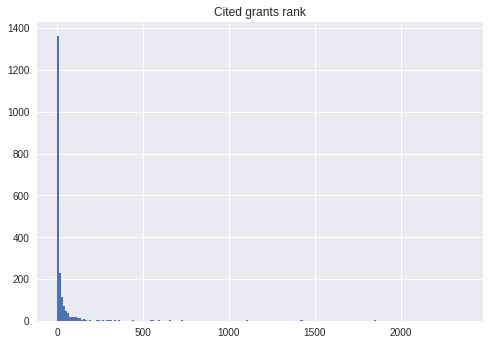

In [22]:
plt.hist(whole_ranks, bins=200)
plt.title("Cited grants rank")
plt.show()

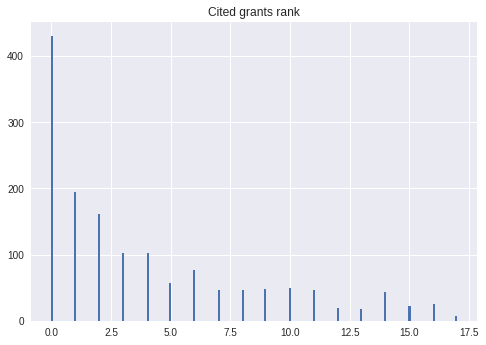

In [23]:
plt.hist(sorted(whole_ranks)[0:1500], bins=200)
plt.title("Cited grants rank")
plt.show()

In [32]:
sum(np.array(whole_ranks) < 10)

1265

In [27]:
sum(np.array(whole_ranks) <= 20)

1548

Draw rank-cover curve

In [0]:
whole_ranks_arr = np.array(whole_ranks)

In [35]:
whole_ranks_arr.max()

2362

In [0]:
positive_counts = [sum(whole_ranks_arr <= thrd) for thrd in range(WHOLE_GRANTS_NUM)]

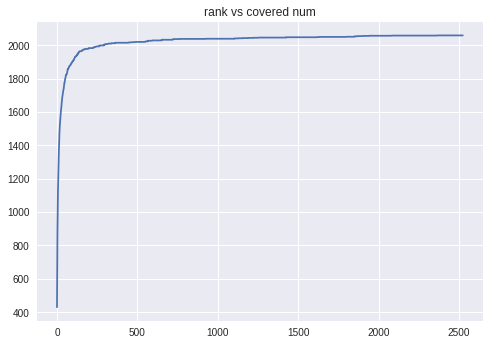

In [39]:
plt.plot(range(WHOLE_GRANTS_NUM), positive_counts)
plt.title("rank vs covered num")
plt.show()

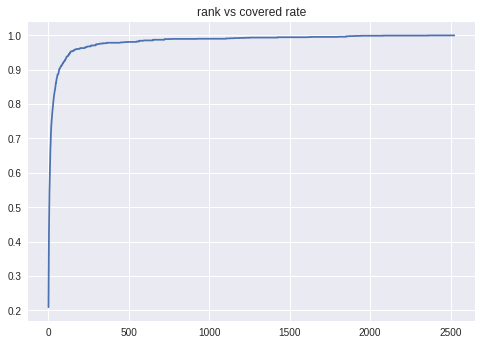

In [42]:
plt.plot(range(WHOLE_GRANTS_NUM), np.array(positive_counts)/len(whole_tups))
plt.title("rank vs covered rate")
plt.show()

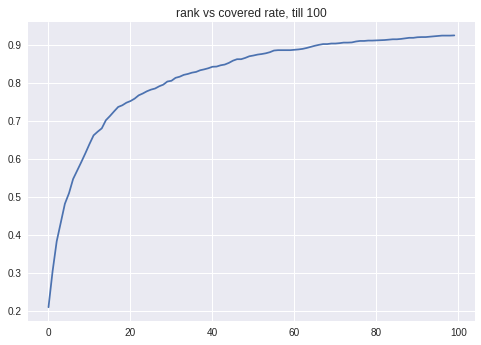

In [43]:
plt.plot(range(100), (np.array(positive_counts)/len(whole_tups))[0:100])
plt.title("rank vs covered rate, till 100")
plt.show()

In [44]:
sum(whole_ranks_arr<10)/len(whole_tups)

0.6143759106362312

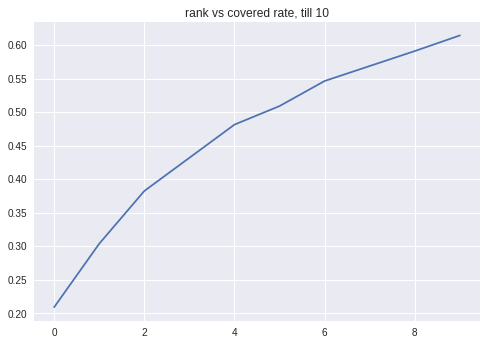

In [45]:
plt.plot(range(10), (np.array(positive_counts)/len(whole_tups))[0:10])
plt.title("rank vs covered rate, till 10")
plt.show()

# Benchmark 2000 evaluation.

### Evaluation code from below notebook

https://github.com/karino2/US-patent-analysis/blob/master/notebook/tfidf_nearest.ipynb

We do not need claim text (because we already use it and save the result), but put those utility to re-use evaluation code.

In [0]:
import re

CLAIM_PAT = re.compile(r'<claims[^>]*>(.*)</claims>',re.MULTILINE|re.DOTALL)
TAG_PAT = re.compile(r"<.*?>")


def whole_xml_to_claim_xml(whole):
    mat = CLAIM_PAT.search(whole)
    return mat.group(1)
  
  
def whole_xml_to_claim(whole):
    return TAG_PAT.sub(' ', whole_xml_to_claim_xml(whole))

In [0]:
def predict_test_set(predict_func):
    """
    predict_func(claims) return NxM of boolean. N is len(claims). M is rownum of grants_target_df.
            value indicate n claim is cite patent of m row of grants_all_df.
    """
    predictdf = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
    res = predict_func(testset_app_df["xml"].map(whole_xml_to_claim))
    for idx, appid in enumerate(testset_app_df.app_id):
        predictdf.loc[appid] = res[idx, :]
    return predictdf

In [0]:
def calc_TPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_FPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_TNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_FNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_TFPNs(preddf, labeldf):
    return calc_TPs(preddf, labeldf), calc_FPs(preddf, labeldf), calc_TNs(preddf, labeldf), calc_FNs(preddf, labeldf)

In [0]:
def calc_summary_TFPNs(TP, FP, TN, FN):
    "return acc, prec, recall, f1."
    return pd.DataFrame(columns=["acc", "prec", "recall", "f1"], data=[[(TP+TN)/(TP+FP+TN+FN), TP/(TP+FP), TP/(TP+FN), 2*TP/(2*TP+FP+FN)]])
    
def calc_summary(preddf, labeldf):
    TP, FP, TN, FN = calc_TFPNs(preddf, labeldf)
    return calc_summary_TFPNs(TP, FP, TN, FN)

In [0]:
def set_one_answer_appid(labeldf, oneappid):
    cited_patids = citations_info_target[citations_info_target.app_id == oneappid].parsed
    labeldf.loc[oneappid] = labeldf.columns.isin(cited_patids)
    
    
def create_label_df():
    label_df = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
    for appid in testset_app_df.app_id:
        set_one_answer_appid(label_df, appid)
    return label_df

### Bert predict function

Bert predict takes too much time to evaluate on the fly.
So I predict whole test set one block by one block (20 patents each), then save result in another notebook.

https://github.com/karino2/US-patent-analysis/blob/bert_input/colab/bert_benchmark_2000_save_result.ipynb

So here, we just use index of input as the id of input and pickup the result already computed.


In [48]:
np.array(load_result(0))[:,1]

array([0.0001288 , 0.00012526, 0.00013392, ..., 0.00023892, 0.00012708,
       0.00015882], dtype=float32)

In [0]:
whole_pair_scores = [score for block_id in range(50) for score in np.array(load_result(block_id))[:, 1]]

In [50]:
len(whole_pair_scores)

2524000

In [0]:
score_matrix = np.array(whole_pair_scores).reshape((1000, -1))

In [72]:
score_matrix.shape

(1000, 2524)

In [73]:
score_matrix[1, 0:5]

array([1.3072522e-04, 1.2457161e-04, 1.9968447e-01, 1.2207238e-04,
       1.3056371e-04], dtype=float32)

In [74]:
whole_pair_scores[2524: 2524+5]

[0.00013072522, 0.00012457161, 0.19968447, 0.00012207238, 0.00013056371]

In [0]:
SOFT_MAX_THRESHOLD=0.5

def predict_bertf_model(claims):
    """
    return: NxM of boolean. N is len(claims). M is rownum of grants_all_df.
            value indicate n claim is cite patent of m row of grants_all_df.
    """
    return score_matrix > SOFT_MAX_THRESHOLD


In [0]:
pred_df = predict_test_set(predict_bertf_model)

In [85]:
label_df = create_label_df()
label_df.shape

(1000, 2524)

In [90]:
SOFT_MAX_THRESHOLD=0.5
pred_df = predict_test_set(predict_bertf_model)
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.945267,0.008382,0.932854,0.016614


### Manual grid search for best f1 score

We should use validation set for real evaluation.
But now just check the effectivity of bert.

In [88]:
SOFT_MAX_THRESHOLD=0.8
pred_df = predict_test_set(predict_bertf_model)
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.947257,0.008688,0.932054,0.017216


In [89]:
SOFT_MAX_THRESHOLD=0.99
pred_df = predict_test_set(predict_bertf_model)
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.953794,0.009781,0.920064,0.019357


In [93]:
SOFT_MAX_THRESHOLD=0.999
pred_df = predict_test_set(predict_bertf_model)
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.962702,0.011876,0.903277,0.023444


In [94]:
SOFT_MAX_THRESHOLD=0.9999
pred_df = predict_test_set(predict_bertf_model)
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.994926,0.055534,0.577138,0.101319


In [105]:
SOFT_MAX_THRESHOLD=0.9999134
pred_df = predict_test_set(predict_bertf_model)
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.999505,1.0,0.000799,0.001597


In [106]:
SOFT_MAX_THRESHOLD=0.99991
pred_df = predict_test_set(predict_bertf_model)
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.999391,0.229602,0.096723,0.136108


In [102]:
np.array(whole_pair_scores).max()

0.99991345

# Try and error

In [0]:
filename = result_block_filename(0)
filename

'result_0_50480.pkl.gz'

In [0]:
cited_ranking(2, 1, result_block)

idx:22, ridx:2


[(13004544, 6845583, 0, 0.9999095)]

In [0]:
testset_app_df.app_id[22]

13004544

In [0]:
pd.DataFrame({"rank": sorted(block_ranks)})

,rank
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [0]:
result_block = load_result(1)

In [0]:
block_rank_tuples = [tup for apprid in range(APPS_PER_BLOCK) for tup in cited_ranking(apprid, 1, result_block)]

In [0]:
block_ranks = [tup[2] for tup in block_rank_tuples]

In [0]:
block_ranks[0:5]

[81, 0, 0, 0, 0]

In [0]:
sorted(block_ranks)[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2]

In [0]:
len(block_rank_tuples)

54

In [0]:
import matplotlib.pyplot as plt

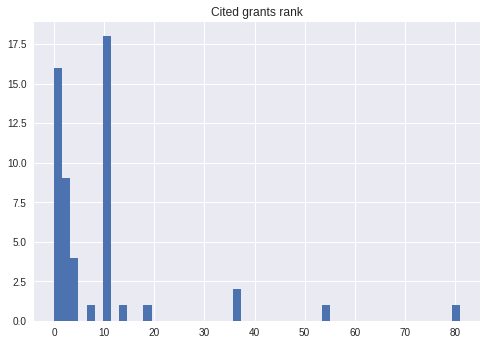

In [0]:
plt.hist(block_ranks, bins=50)
plt.title("Cited grants rank")
plt.show()

In [0]:
tmp = np.array(range(10))

In [0]:
tmp.reshape((2, -1))

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [0]:
tmp.reshape((2, -1))[0, :]

array([0, 1, 2, 3, 4])

In [0]:
def appidx_to_range(appidx):
  return appidx*WHOLE_GRANTS_NUM, (appidx+1)*WHOLE_GRANTS_NUM

In [0]:
appidx_to_range(19)

(47956, 50480)

In [0]:
whole_pair_scores[0:5]

[0.00012879973, 0.00012525565, 0.00013391985, 0.00012690226, 0.00013221534]

In [0]:
def appidx_to_scores(appidx):
  start, end = appidx_to_range(appidx)
  return whole_pair_scores(start, end)